In [158]:
import h5py
import numpy as np
%matplotlib inline
import matplotlib.style
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('classic')
from mpl_toolkits.axes_grid1 import make_axes_locatable
import subprocess

from scipy.interpolate import RectBivariateSpline, interp2d
from scipy.ndimage import map_coordinates

In [272]:
py_directory = "./"
py_directory += "output_travelling_vortex/"

# inner = (slice(2,-2),slice(2,-2))
inner = (slice(None,),slice(None,))

def spatially_averaged_rmse(arr,ref):
    n,m = ref.shape
    N = n * m
    return (((arr - ref)**2).sum() / N)**0.5

def get_filename(grid_x,grid_y,size,end_time,suffix):
    return "output_travelling_vortex_ensemble=" + str(size) + "_" + str(grid_x) + "_" + str(grid_y) + "_" + str(end_time) + suffix + ".h5"

def get_path(filename):
    return py_directory + filename

def py_out(pyfile,py_dataset,time):
    return pyfile[str(py_dataset)][str(py_dataset)+time][:]

def ensemble_test_case(time, path, N, attribute):
    file = h5py.File(path,'r')
    
    array = []
    for n in range(N):
        t_label = '_ensemble_mem=%i_%.2f_after_full_step' %(n,time)
        array.append(py_out(file,attribute,time=t_label)[inner])

    array = np.array(array)
    array = array.mean(axis=0)

    file.close()
    file.close()
    return array

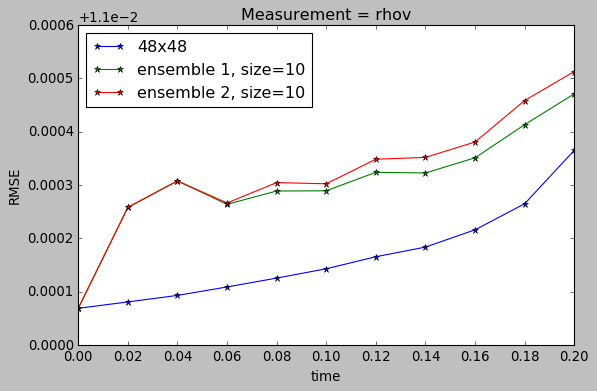

In [321]:
ref_grid_x = 256
ref_grid_y = 256
grid_x = 48
grid_y = 48
ref_size = 1
ens_size_1 = 10
ens_size_2 = 10
end_time = 0.2
print_output = False
ens_2 = True
interpolation_method = "map_coordinates"
# interpolation_method = "interp2d"
mode, order = 'wrap', 3

inner = (slice(2,-2),slice(2,-2))
# inner = (slice(None,),slice(None,))

# times = np.arange(0,11) / 10
times= [0.0,0.02,0.04, 0.06, 0.08, 0.10, 0.12, 0.14, 0.16, 0.18,0.20]
# times = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
attributes = ['rhov']

py_filename_ref = get_filename(ref_grid_x, ref_grid_y, ref_size, end_time, "")
py_path_ref = get_path(py_filename_ref)

py_filename_ref_1 = get_filename(grid_x,grid_y,ref_size,end_time, "")
py_path_ref_1 = get_path(py_filename_ref_1)

py_filename_ens_1 = get_filename(grid_x,grid_y,ens_size_1,end_time, "")
py_path_ens_1 = get_path(py_filename_ens_1)

if ens_2 == True:
    py_filename_ens_2 = get_filename(grid_x,grid_y,ens_size_2,end_time, "_noda")
    py_path_ens_2 = get_path(py_filename_ens_2)

rmse_ref_1, rmse_ens_1, rmse_ens_2 = [], [], []


for attribute in attributes:
    cnt = 0
    for time in times:
        comp_ref = ensemble_test_case(time, py_path_ref,ref_size, attribute)
        comp_ref_inner = comp_ref[inner]
        comp_ref_1 = ensemble_test_case(time, py_path_ref_1,ref_size, attribute)
        comp_ref_1_inner = comp_ref_1[inner]
        
        if interpolation_method == "map_coordinates":
            x = np.linspace(0,comp_ref_1.shape[0],comp_ref.shape[0])
            y = np.linspace(0,comp_ref_1.shape[1],comp_ref.shape[1])

            # x = np.linspace(0,comp_ref_1.shape[0]-1,comp_ref.shape[0])
            # a = -1
            # b = -1
            # x = np.arange(comp_ref.shape[0]) / (comp_ref.shape[0] + a) * (comp_ref_1.shape[0] + b)
            # y = np.arange(comp_ref.shape[1]) / (comp_ref.shape[1] + a) * (comp_ref_1.shape[1] + b)
            # y = np.linspace(0,comp_ref_1.shape[0]-2,comp_ref.shape[1])

            x,y = np.meshgrid(x,y)
            comp_ref_1 = map_coordinates(comp_ref_1,[y,x],mode=mode,order=order)

        if interpolation_method == "interp2d":
            x = np.linspace(-0.5,0.5,comp_ref_1.shape[0])
            y = np.linspace(-0.5,0.5,comp_ref_1.shape[1])

            x0 = np.linspace(-0.5,0.5,comp_ref.shape[0])
            y0 = np.linspace(-0.5,0.5,comp_ref.shape[1])
            mesh = np.array(np.meshgrid(x0,y0))
            pts = np.rollaxis(mesh, 0, 3).reshape((-1, 2))
            xs_ref = comp_ref.shape[0]
            ys_ref = comp_ref.shape[1]
        
            comp_ref_1 = interpn((x,y),comp_ref_1,pts, method='linear').reshape(xs_ref,ys_ref).T

        # interpol_ref_1 = RectBivariateSpline(np.linspace(-0.5,0.5,48),np.linspace(-0.5,0.5,48),comp_ref_1)
        # x0 = np.linspace(-0.5,0.5,256)
        # y0 = np.linspace(-0.5,0.5,256)
        # comp_ref_1 = interpol_ref_1(x0,y0)

        comp_ens_1 = ensemble_test_case(time, py_path_ens_1, ens_size_1, attribute)

        # interpol_ens_1 = RectBivariateSpline(np.linspace(-0.5,0.5,48),np.linspace(-0.5,0.5,48),comp_ens_1)
        # x0 = np.linspace(-0.5,0.5,comp_ref.shape[0])
        # y0 = np.linspace(-0.5,0.5,comp_ref.shape[1])
        # comp_ens_1 = interpol_ens_1(x0,y0)

        if interpolation_method == "map_coordinates":
            comp_ens_1 = map_coordinates(comp_ens_1,[y,x],mode=mode,order=order)
            # comp_ens_1 = comp_ens_1[inner]
        if interpolation_method == "interp2d":
            comp_ens_1 = interpn((x,y),comp_ens_1,pts, method='linear').reshape(xs_ref,ys_ref).T

        comp_ref = comp_ref[inner]
        comp_ref_1 = comp_ref_1[inner]   
        comp_ens_1 = comp_ens_1[inner]

        rmse_ref_1.append(spatially_averaged_rmse(comp_ref_1,comp_ref))
        rmse_ens_1.append(spatially_averaged_rmse(comp_ens_1,comp_ref))

        if ens_2 == True:
            comp_ens_2 = ensemble_test_case(time, py_path_ens_2, ens_size_2, attribute)
            if interpolation_method == "map_coordinates":
                comp_ens_2 = map_coordinates(comp_ens_2,[y,x],mode=mode,order=order)
                
            if interpolation_method == "interp2d":
                comp_ens_2 = interpn((x,y),comp_ens_2,pts, method='linear').reshape(xs_ref,ys_ref).T

            comp_ens_2 = comp_ens_2[inner]
            rmse_ens_2.append(spatially_averaged_rmse(comp_ens_2,comp_ref))

        if len(attributes) == 1 and print_output == True:
            nocol = 4 if ens_2 == True else 3
            fig, ax = plt.subplots(ncols=nocol, figsize=(9,3))

            img = ax[0].imshow(comp_ref)
            ax[0].set_title("ref: (%ix%i)" %(ref_grid_x,ref_grid_y))
            img = ax[1].imshow(comp_ref_1)
            ax[1].set_title("ref: (%ix%i)" %(grid_x, grid_y))
            img = ax[2].imshow(comp_ens_1)
            ax[2].set_title("DA: ens size=%i" %ens_size_1)
            if ens_2 == True:
                img = ax[3].imshow(comp_ens_2)
                ax[3].set_title("DA: ens size=%i" %ens_size_2)

            fig.colorbar(img, ax=ax, shrink=.75)
            fig.suptitle("time=%.2f, measurement=%s" %(time,attribute))
            plt.savefig("./output_images/%03d" %cnt, bbox_inches='tight')
            plt.show()

        cnt += 1

plt.figure(figsize=(8,5))
plt.plot(times,rmse_ref_1, '-*',label=str(grid_x) + 'x' + str(grid_y))
plt.plot(times,rmse_ens_1, '-*',label='ensemble 1, size=' + str(ens_size_1))
if ens_2 == True:
    plt.plot(times,rmse_ens_2, '-*',label='ensemble 2, size=' + str(ens_size_2))
plt.title("Measurement = %s" %attribute)
plt.xlabel("time")
plt.ylabel("RMSE")
plt.legend(loc='best')
plt.xticks(times)
plt.savefig("rmse_" + attribute, bbox_inches='tight')
plt.show()

file = h5py.File(py_directory + py_filename_ens_1, 'r')
if file.__bool__():
    file.close()
if ens_2 == True:
    file = h5py.File(py_directory + py_filename_ens_2, 'r')
    if file.__bool__():
        file.close()

In [139]:
/A = np.arange(49152).reshape(4,3,64,64)
print(A.shape)
print(A[:,0,...].shape)

(4, 3, 64, 64)
(4, 64, 64)


In [184]:
A = np.arange(12).reshape(3,4)
print(A)
B = np.arange(4)
print(A+B)


[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]]
[[ 0  2  4  6]
 [ 4  6  8 10]
 [ 8 10 12 14]]


In [523]:
file.close()

In [569]:
interp_x = 3.5           # Only one value on the x1-axis
interp_y = np.arange(10) # A range of values on the x2-axis

# Note the following two lines that are used to set up the
# interpolation points as a 10x2 array!
interp_mesh = np.array(np.meshgrid(interp_x, interp_y))
interp_points = np.rollaxis(interp_mesh, 0, 3).reshape((10, 2))

print(interp_x)
print(interp_y)

print(interp_mesh)
print(interp_points)

3.5
[0 1 2 3 4 5 6 7 8 9]
[[[3.5]
  [3.5]
  [3.5]
  [3.5]
  [3.5]
  [3.5]
  [3.5]
  [3.5]
  [3.5]
  [3.5]]

 [[0. ]
  [1. ]
  [2. ]
  [3. ]
  [4. ]
  [5. ]
  [6. ]
  [7. ]
  [8. ]
  [9. ]]]
[[3.5 0. ]
 [3.5 1. ]
 [3.5 2. ]
 [3.5 3. ]
 [3.5 4. ]
 [3.5 5. ]
 [3.5 6. ]
 [3.5 7. ]
 [3.5 8. ]
 [3.5 9. ]]
